# Getting Started with Reverse Image Search

## Preparation

### Dataset

The image dataset is a subset of the ImageNet (100 classes, 10 images for each class). Anyone can download the on [Google Drive](https://drive.google.com/file/d/1lRhHODcFXUEHf7n-GFlvYgBikhg81KbB/view?usp=sharing) or [GitHub](https://github.com/towhee-io/data/raw/main/image/reverse_image_search.zip), and we will use `wget` to download and unzip the data.

In [1]:
! wget https://github.com/towhee-io/data/raw/main/image/reverse_image_search.zip
! unzip -q reverse_image_search.zip

--2022-05-07 16:19:41--  https://github.com/towhee-io/data/raw/main/image/reverse_image_search.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/towhee-io/data/main/image/reverse_image_search.zip [following]
--2022-05-07 16:19:42--  https://media.githubusercontent.com/media/towhee-io/data/main/image/reverse_image_search.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124900817 (119M) [application/zip]
Saving to: ‘reverse_image_search.zip’

reverse_image_searc 100%[===================>] 119.11M  17.1MB/s    in 8.1s    

2022-05-07 16:19:51 (14.7 MB/s) - ‘reverse_image_se

The image dataset contains two directories - **extracted_train** for the image dataset and **extracted_test** for the query images, and **reverse_image_search.csv** contains three columns of ***id***, ***path***, and ***label***. Let's take a look about this file.

In [2]:
import pandas as pd

df = pd.read_csv('reverse_image_search.csv')

id_img = df.set_index('id')['path'].to_dict()
label_ids = {}
for label in set(df['label']):
    label_ids[label] = list(df[df['label']==label].id)
    
df.head()

,id,path,label
0,0,./extracted_train/n01917289/n01917289_1783.JPEG,n01917289
1,1,./extracted_train/n01917289/n01917289_4317.JPEG,n01917289
2,2,./extracted_train/n01917289/n01917289_765.JPEG,n01917289
3,3,./extracted_train/n01917289/n01917289_1079.JPEG,n01917289
4,4,./extracted_train/n01917289/n01917289_2484.JPEG,n01917289


Then we get the dictionary `id_img` of id and image path, which is used to get the image corresponding to the id after searching. And `lable_ids` is a list of all ids with the same label, which is used for accuracy metric.

### Milvus & Towhee

[Milvus](https://milvus.io/) is an open-source vector database built to power embedding similarity search

[Towhee](https://towhee.io/) is a framework that helps you encode your unstructured data into embeddings.

Towhee has combined with Milvus for end-to-end unstructured data processing. In the reverse image search system Towhee is always used to generate embedding vectors and Milvus store and search vectors.

<img src="./workflow.png" width = "60%" height = "60%" align=center />

So we have to install milvus and towhee, And in this notebook will install [embedded Milvus](https://github.com/milvus-io/embd-milvus) and you can also install the [distribute version](https://milvus.io/docs/v2.0.x/install_cluster-docker.md). Then create a `reverse_image_search` collection and build [IVF_FLAT](https://milvus.io/docs/v2.0.x/index.md#IVF_FLAT) index for it.

- Install Towhee and Milvus.

In [3]:
# ! python -m pip install milvus
# ! python -m pip install towhee

- Create collection and index

In [4]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

# create reverse_image_search collection and build index
def create_milvus_collection(collection_name, dim):
    connections.connect(host='127.0.0.1', port='19530')
    
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
    FieldSchema(name='id', dtype=DataType.INT64, descrition='ids', is_primary=True, auto_id=False),
    FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, descrition='embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='reverse image search')
    collection = Collection(name=collection_name, schema=schema)

    # create IVF_FLAT index for collection.
    index_params = {
        'metric_type':'L2',
        'index_type':"IVF_FLAT",
        'params':{"nlist":2048}
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    return collection


collection = create_milvus_collection('reverse_image_search', 2048)

## Two Steps for Reverse Image Search

For the reverse image search solution of towhee and milvus, it mainly includes two steps of insertion and search.

The insertion process first uses Towhee to read all image data, then uses the `resnet50` model to extract the feature vector of the image, and finally inserts them into the created Milvus collection.

In [5]:
%%time
import towhee

dc = (towhee.read_csv('reverse_image_search.csv')
      .runas_op['id', 'id'](func=lambda x: int(x))
      .image_decode['path', 'img']()
      .image_embedding.timm['img', 'vec'](model_name='resnet50')
      .tensor_normalize['vec', 'vec']()
      .to_milvus['id', 'vec'](collection=collection, batch=100)
)

CPU times: user 8min 29s, sys: 15.9 s, total: 8min 45s
Wall time: 1min 38s


As you can see, `image_embedding.timm` is used to generate image embedding vector, it is an operator in [towhee hub](https://towhee.io/image-embedding/timm) where you can find more models for embedding. And you can learn other towhee interfaces in the above code from [here](https://towhee.readthedocs.io/en/main/index.html).

Then we can use `collection.num_entities` to get the number of inserted data, it will be 1000.

In [6]:
collection.num_entities

1000

After inserting the data, we can search for similar images. First use Towhee to get the query image, `resnet50` model to extract the feature vector, and then search in milvus to get the result. 

But here the result only contains the `id` and `distance`, so there is `get_result_imgs` function to get the image based on the `id` and finally show the similar images.

img,result_img
,
,
,

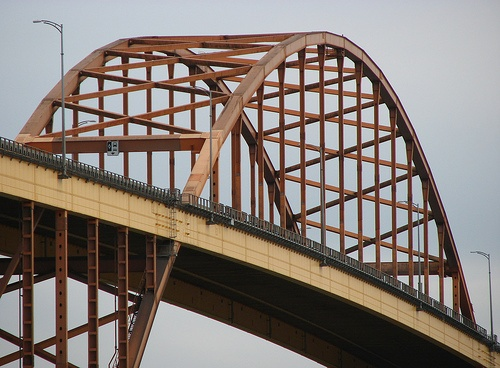
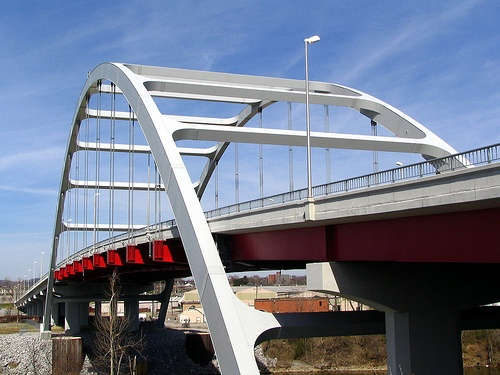
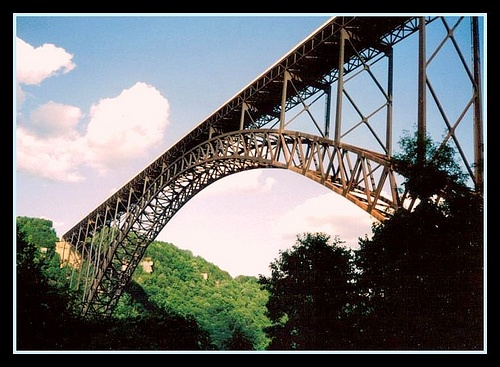
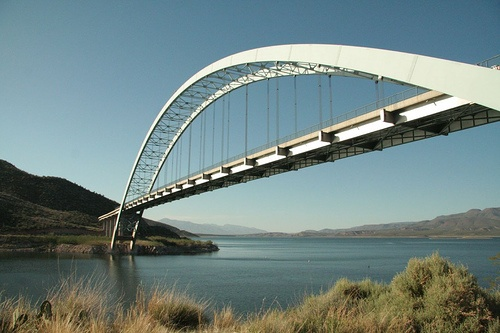
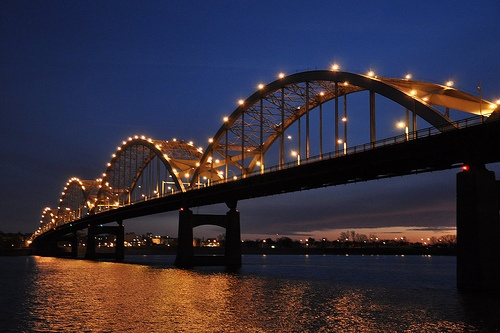
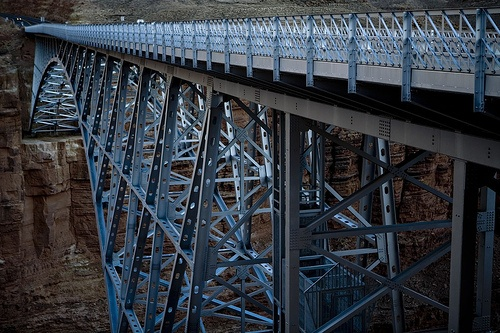
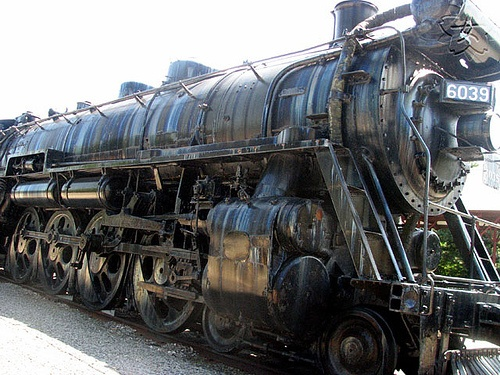
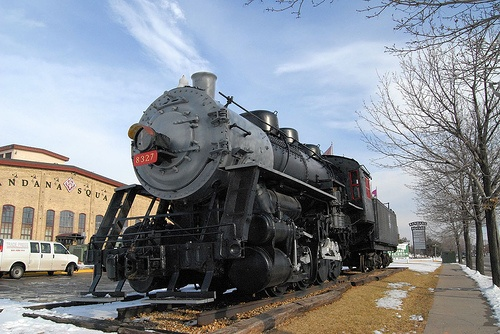
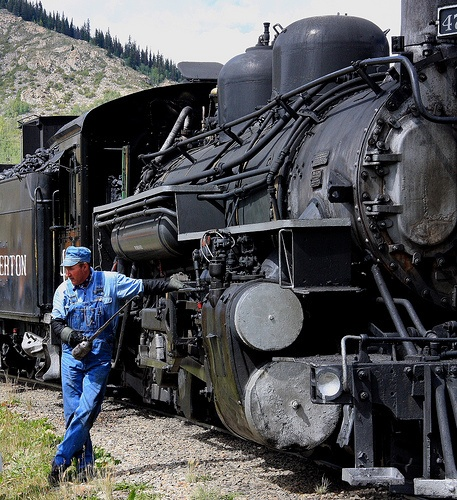
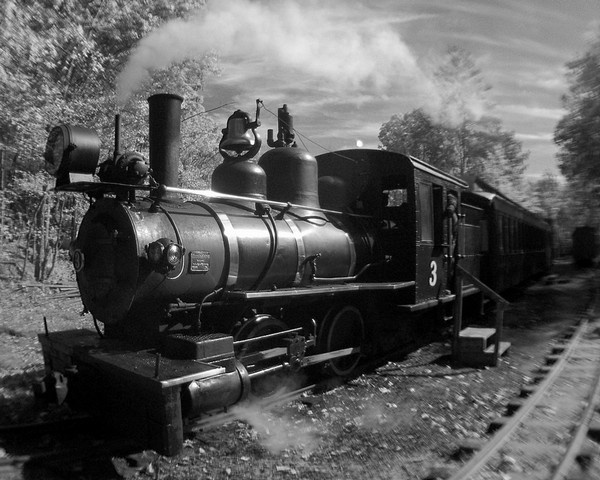
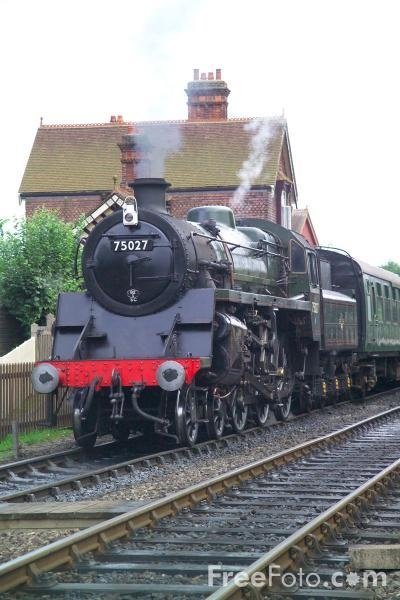
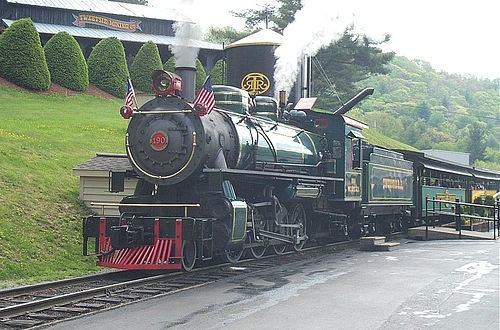
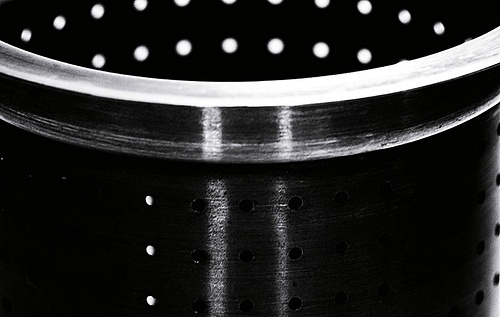
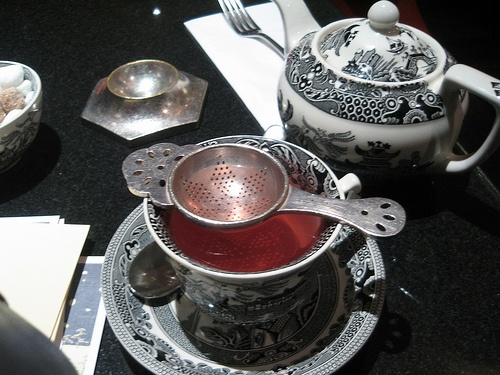
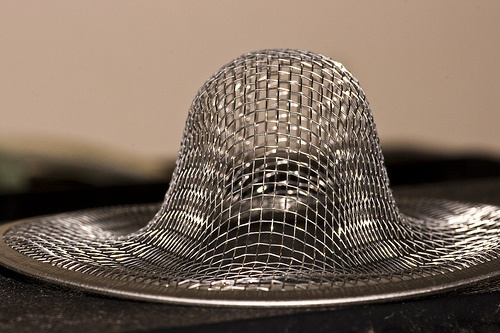
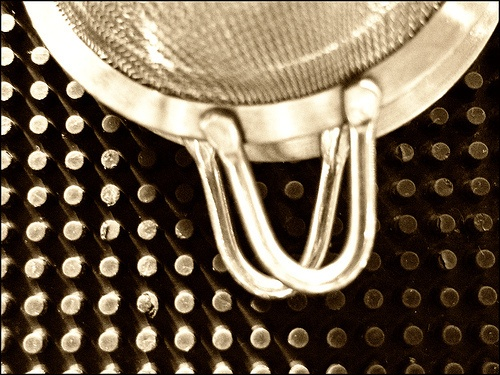
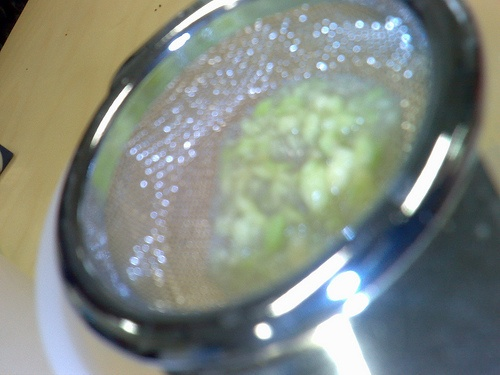
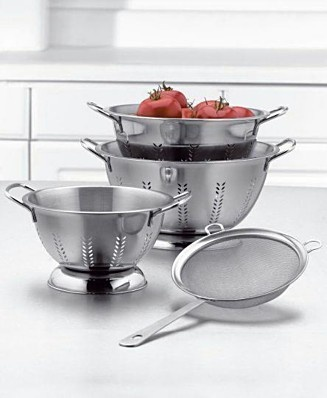

CPU times: user 2.24 s, sys: 203 ms, total: 2.44 s
Wall time: 1.04 s


In [7]:
%%time

import cv2
from towhee._types.image import Image

def get_result_imgs(results):
    imgs = []
    for re in results:
        path = id_img[re.id]
        imgs.append(Image(cv2.imread(path), 'BGR'))
    return imgs

(towhee.glob['path']('./extracted_test/n043*/*.JPEG')
      .image_decode['path', 'img']()
      .image_embedding.timm['img', 'vec'](model_name='resnet50')
      .tensor_normalize['vec', 'vec']()
      .milvus_search['vec', 'result'](collection=collection, limit=5)
      .runas_op['result', 'result_img'](func=get_result_imgs)
      .select['img', 'result_img']()
      .show()
)

## Play with Gradio

It's funny to start the image search service with [Gradio](https://gradio.app/), it will start an interactive search interface. We just need to define the `search_in_milvus` function to pass in an image and return similar images.

In [8]:
from towhee.types.image_utils import from_pil
import gradio

with towhee.api() as api:
    search_in_milvus = (
        api.runas_op(func=lambda img: from_pil(img))
        .image_embedding.timm(model_name='resnet50')
        .tensor_normalize()
        .milvus_search(collection='reverse_image_search', limit=5)
        .runas_op(func=lambda res: [id_img[x.id] for x in res])
        .as_function()
        )

interface = gradio.Interface(search_in_milvus, 
                             gradio.inputs.Image(type="pil", source='upload'),
                             [gradio.outputs.Image(type="file", label=None) for _ in range(5)]
                            )

interface.launch(inline=True, share=True)

Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://21477.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7f9f496cd8b0>,
 'http://127.0.0.1:7860/',
 'https://21477.gradio.app')

## Run with Multi Models and Repot the Accuracy Metrics

You may want to try other models, then we can compare the accuracy of the models for selection. There are two models(`resnet50` and `resnet101`) to run with reverse image search, and it will report the accuracy metrics.

- **mean_hit_ratio**

Divide the number of result hits with the number of ground-truth.

- **mean_average_precision**

Compares the ground-truth topk to the result box.


In [10]:
%%time
model_dim = {
    'resnet50': 2048,
    'resnet101': 2048
}

for model in model_dim:
    collection = create_milvus_collection(model, model_dim[model])
        
    (towhee.read_csv('reverse_image_search.csv')
        .runas_op['id', 'id'](func=lambda x: int(x))
        .image_decode['path', 'img']()
        .image_embedding.timm['img', 'vec'](model_name=model)
        .tensor_normalize['vec', 'vec']()
        .to_milvus['id', 'vec'](collection=collection, batch=100)
    )
    
    (towhee.glob['path']('./extracted_test/*/*.JPEG')
        .image_decode['path', 'img']()
        .image_embedding.timm['img', 'vec'](model_name=model)
        .tensor_normalize['vec', 'vec']()
        .runas_op['path', 'ground_truth'](func=lambda path: label_ids[path.split('/')[-2]])
        .milvus_search['vec', 'result'](collection=collection)
        .runas_op['result', 'result'](func=lambda res: [x.id for x in res])
        .with_metrics(['mean_hit_ratio', 'mean_average_precision'])
        .evaluate['ground_truth', 'result'](model)
        .report()
    )

,mean_hit_ratio,mean_average_precision
resnet50,0.781,0.917373


,mean_hit_ratio,mean_average_precision
resnet101,0.937,0.973761


CPU times: user 29min 26s, sys: 27.5 s, total: 29min 54s
Wall time: 6min 10s


As you can see, the `resnet101` has better perfermance than `resnet50`. If you want to compare with more models and tools, you can refer to [advanced.ipynb](./advanced.ipynb), and it will also introduce how to deploy a reverse image search server.